In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
sys.path.append('..')

import numpy as np
from tqdm import tqdm
import time

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
mpl.rc_file('../matplotlibrc')

In [2]:
# 21cmFAST
import py21cmfast as p21c
from py21cmfast import plotting, cache_tools
print(f'Using 21cmFAST version {p21c.__version__}')

import logging
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:59: UserWarning: Your configuration file is out of date. Updating...
  "Your configuration file is out of date. Updating..."
/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


Using 21cmFAST version 0.1.dev1578+g6f96f89.d20230224


In [3]:
from dm21cm.injection import get_input_boxs, DMParams

## 0. Global config

In [4]:
! lscpu | grep "CPU(s)"

CPU(s):                48
On-line CPU(s) list:   0-47
NUMA node0 CPU(s):     0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46
NUMA node1 CPU(s):     1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47


In [5]:
N_THREADS = 32

## 1. Run

In [6]:
def get_z_arr(z_start=None, z_end=20):
    
    if z_start is None:
        z_start = p21c.global_params.Z_HEAT_MAX
    z_arr = [z_end]
    while np.max(z_arr) < z_start:
        z_prev = (1 + np.max(z_arr)) * p21c.global_params.ZPRIME_STEP_FACTOR - 1
        z_arr.append(z_prev)
    return np.array(z_arr[::-1][1:])

In [7]:
# check cached runs
CACHE_DIR_BASE = '/scratch/submit/ctp/yitians/21cmFAST-cache'
os.listdir(CACHE_DIR_BASE)

['emf_comp_spf_mh3',
 'emf_comp_dh_mh3',
 'emf_comp_dh_mh6',
 'emf_comp_dh_mh9',
 'emf_comp_base']

In [57]:
# run config
RUN_NAME = 'emf_comp_spf_mh3'
f_scheme = 'SPF'
struct_boost_model = 'erfc 1e-3'
run_mode = 'inj'

p21c.config['direc'] = f'{CACHE_DIR_BASE}/{RUN_NAME}'
os.makedirs(p21c.config['direc'], exist_ok=True)

In [ ]:
cache_tools.clear_cache()

In [59]:
cosmo_params_EMF = dict(OMm=0.32, OMb=0.049, POWER_INDEX=0.96, SIGMA_8=0.83, hlittle=0.67)

# initialize
initial_conditions = p21c.initial_conditions(
    user_params = p21c.UserParams(
        HII_DIM=50, # [1]
        BOX_LEN=50, # [p-Mpc]
        N_THREADS=N_THREADS
    ),
    cosmo_params = p21c.CosmoParams(**cosmo_params_EMF),
    random_seed=54321, write=True
)

# redshift
p21c.global_params.ZPRIME_STEP_FACTOR = 1.05
p21c.global_params.Z_HEAT_MAX = 44.
z_arr = get_z_arr(z_end=6.)
print(z_arr)

# dark matter
dm_params = DMParams(mode='swave', primary='mu', m_DM=1e10, sigmav=1e-26)

/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/inputs.py:488: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  "The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be "


[43.69834103 41.5698486  39.54271295 37.61210757 35.77343578 34.02231979
 32.35459028 30.76627646 29.25359663 27.81294917 26.44090397 25.13419426
 23.88970882 22.70448459 21.57569961 20.50066629 19.47682504 18.50173813
 17.57308394 16.68865137 15.84633464 15.04412822 14.28012212 13.55249726
 12.8595212  12.199544   11.57099428 10.97237551 10.40226239  9.85929751
  9.34218811  8.84970296  8.38066948  7.93397094  7.50854375  7.103375
  6.7175      6.35        6.        ]


In [60]:
logging.getLogger('py21cmfast._utils').setLevel(logging.CRITICAL+1)
logging.getLogger('py21cmfast.wrapper').setLevel(logging.CRITICAL+1)

In [61]:
records = []
i_slice = int(initial_conditions.user_params.HII_DIM/2)
input_time_tot = 0.
p21c_time_tot = 0.

for i_z in tqdm(range(len(z_arr))):

    z = z_arr[i_z]
    
    input_timer = time.time()
    if i_z == 0:
        spin_temp = None
        input_heating = input_ionization = input_jalpha = None
    
    else: ## input from second step
        
        input_heating = p21c.input_heating(redshift=z, init_boxes=initial_conditions, write=False)
        input_ionization = p21c.input_ionization(redshift=z, init_boxes=initial_conditions, write=False)
        input_jalpha = p21c.input_jalpha(redshift=z, init_boxes=initial_conditions, write=False)

        if run_mode == '':
            if i_z == 1:
                logger.warning('Not injecting anything in this run!')
            input_boxs = {
                ''
            }

        elif run_mode == 'circle':
            input_heating.input_heating += get_circle_seq_at(LOWRES_DIM, 3, i_z)
            input_ionization.input_ionization += get_circle_seq_at(LOWRES_DIM, 5, 9-i_z) * 1e-3
            input_jalpha.input_jalpha += get_circle_seq_at(LOWRES_DIM, 6, 35-i_z)

        elif run_mode == 'inj':
            z_prev = z_arr[i_z-1]
            
            input_boxs = get_input_boxs(
                delta_box = perturbed_field.density, # [1]
                x_e_box = 1 - ionized_box.xH_box, # [1]
                z_prev = z_arr[i_z-1],
                z = z,
                dm_params = dm_params,
                f_scheme = f_scheme,
                struct_boost_model = struct_boost_model
            )

            input_heating.input_heating += input_boxs['heat']
            input_ionization.input_ionization += input_boxs['ion']
            input_jalpha.input_jalpha += input_boxs['exc']
            
        else:
            raise ValueError(run_mode)
            
    input_time_tot += time.time() - input_timer

    ## step in 21cmFAST
    p21c_timer = time.time()
    perturbed_field = p21c.perturb_field( # perturbed_field controls the redshift
        redshift=z,
        init_boxes=initial_conditions
    )
    spin_temp = p21c.spin_temperature(
        perturbed_field=perturbed_field,
        previous_spin_temp=spin_temp,
        input_heating_box=input_heating,
        input_ionization_box=input_ionization,
        input_jalpha_box=input_jalpha,
        write=True
    )
    ionized_box = p21c.ionize_box(
        spin_temp=spin_temp
    )
    brightness_temp = p21c.brightness_temperature(
        ionized_box=ionized_box,
        perturbed_field=perturbed_field,
        spin_temp=spin_temp
    )
    p21c_time_tot += time.time() - p21c_timer

    ## save results
    if i_z > 0:
        record = {
            'z'   : z,
            'T_s' : np.mean(spin_temp.Ts_box), # [mK]
            'T_b' : np.mean(brightness_temp.brightness_temp), # [K]
            'T_k' : np.mean(spin_temp.Tk_box), # [K]
            'x_e' : np.mean(1 - ionized_box.xH_box), # [1]
        }
        if run_mode == 'inj':
            record_inj = {
                'dE_inj_per_B' : input_boxs['dE_inj_per_B_mean'], # [eV per B]
                'f_heat' : input_boxs['f_heat_mean'],
                'f_ion'  : input_boxs['f_ion_mean'],
                'f_exc'  : input_boxs['f_exc_mean'],
            }
            record.update(record_inj)
        records.append(record)
    
print(f'input used {input_time_tot:.4f} s')
print(f'p21c used {p21c_time_tot:.4f} s')

100%|██████████| 39/39 [01:56<00:00,  2.98s/it]

input used 0.4286 s
p21c used 115.5553 s


In [62]:
arr_records = {k: np.array([r[k] for r in records]) for k in records[0].keys()}
np.save(f'../data/run_info/{RUN_NAME}_records', arr_records)

## 2. DarkHistory comparison

In [6]:
sys.path.append(os.environ['DH_DIR'])

import main

In [7]:
import dm21cm.physics as phys

### 2.1 DM

In [ ]:
soln = main.evolve(
    DM_process='swave', mDM=1e10, sigmav=0, primary='mu',
    start_rs=3000,
    coarsen_factor=12, backreaction=True, reion_switch=True,
    struct_boost=phys.struct_boost_func('erfc 1e-3'),
    verbose=1,
)

In [ ]:
pickle.dump(soln, open('../data/rundh_base_soln.p', 'wb'))

In [ ]:
arr_records = {
    'z' : soln['rs'] - 1,
    'x_e' : soln['x'][:,0],
    'T_k' : soln['Tm']/phys.kB,
    'f_heat' : soln['f']['low']['heat'] + soln['f']['high']['heat'],
    'f_ion' : soln['f']['low']['H ion']  + soln['f']['high']['H ion'] + \
              soln['f']['low']['He ion'] + soln['f']['high']['He ion'],
    'f_exc' : soln['f']['low']['exc'] + soln['f']['high']['exc'],
}

z_low, z_high = 6, 44
z_arr = arr_records['z'][::-1]
i_low = np.searchsorted(z_arr, z_low)
i_high = np.searchsorted(z_arr, z_high)

for k in arr_records.keys():
    arr_records[k] = arr_records[k][::-1][i_low:i_high]

In [ ]:
np.save(f'../data/run_info/rundh_mh3_reion_records', arr_records)

### 2.2 No injection

In [34]:
import darkhistory.physics as dhphys
import darkhistory.history.tla as tla

In [31]:
rs_arr = np.load('../data/run_info/rundh_mh3_records.npy', allow_pickle=True).item()['z'] + 1

In [32]:
arr_records = {
    'z' : rs_arr - 1,
    'x_e' : dhphys.xHII_std(rs_arr) + 2*dhphys.xHeII_std(rs_arr),
    'T_k' : dhphys.Tm_std(rs_arr)/dhphys.kB,
}

In [33]:
np.save(f'../data/run_info/rundh_base_records', arr_records)

In [35]:
soln_reion = tla.get_history(rs_arr[::-1], helium_TLA=True, reion_switch=True)

In [36]:
arr_records = {
    'z' : rs_arr - 1,
    'x_e' : soln_reion[:,1][::-1] + 2*soln_reion[:,2][::-1],
    'T_k' : soln_reion[:,0][::-1]/dhphys.kB,
}

In [37]:
np.save(f'../data/run_info/rundh_base_reion_records', arr_records)

## 2. View

### 2.1 Global

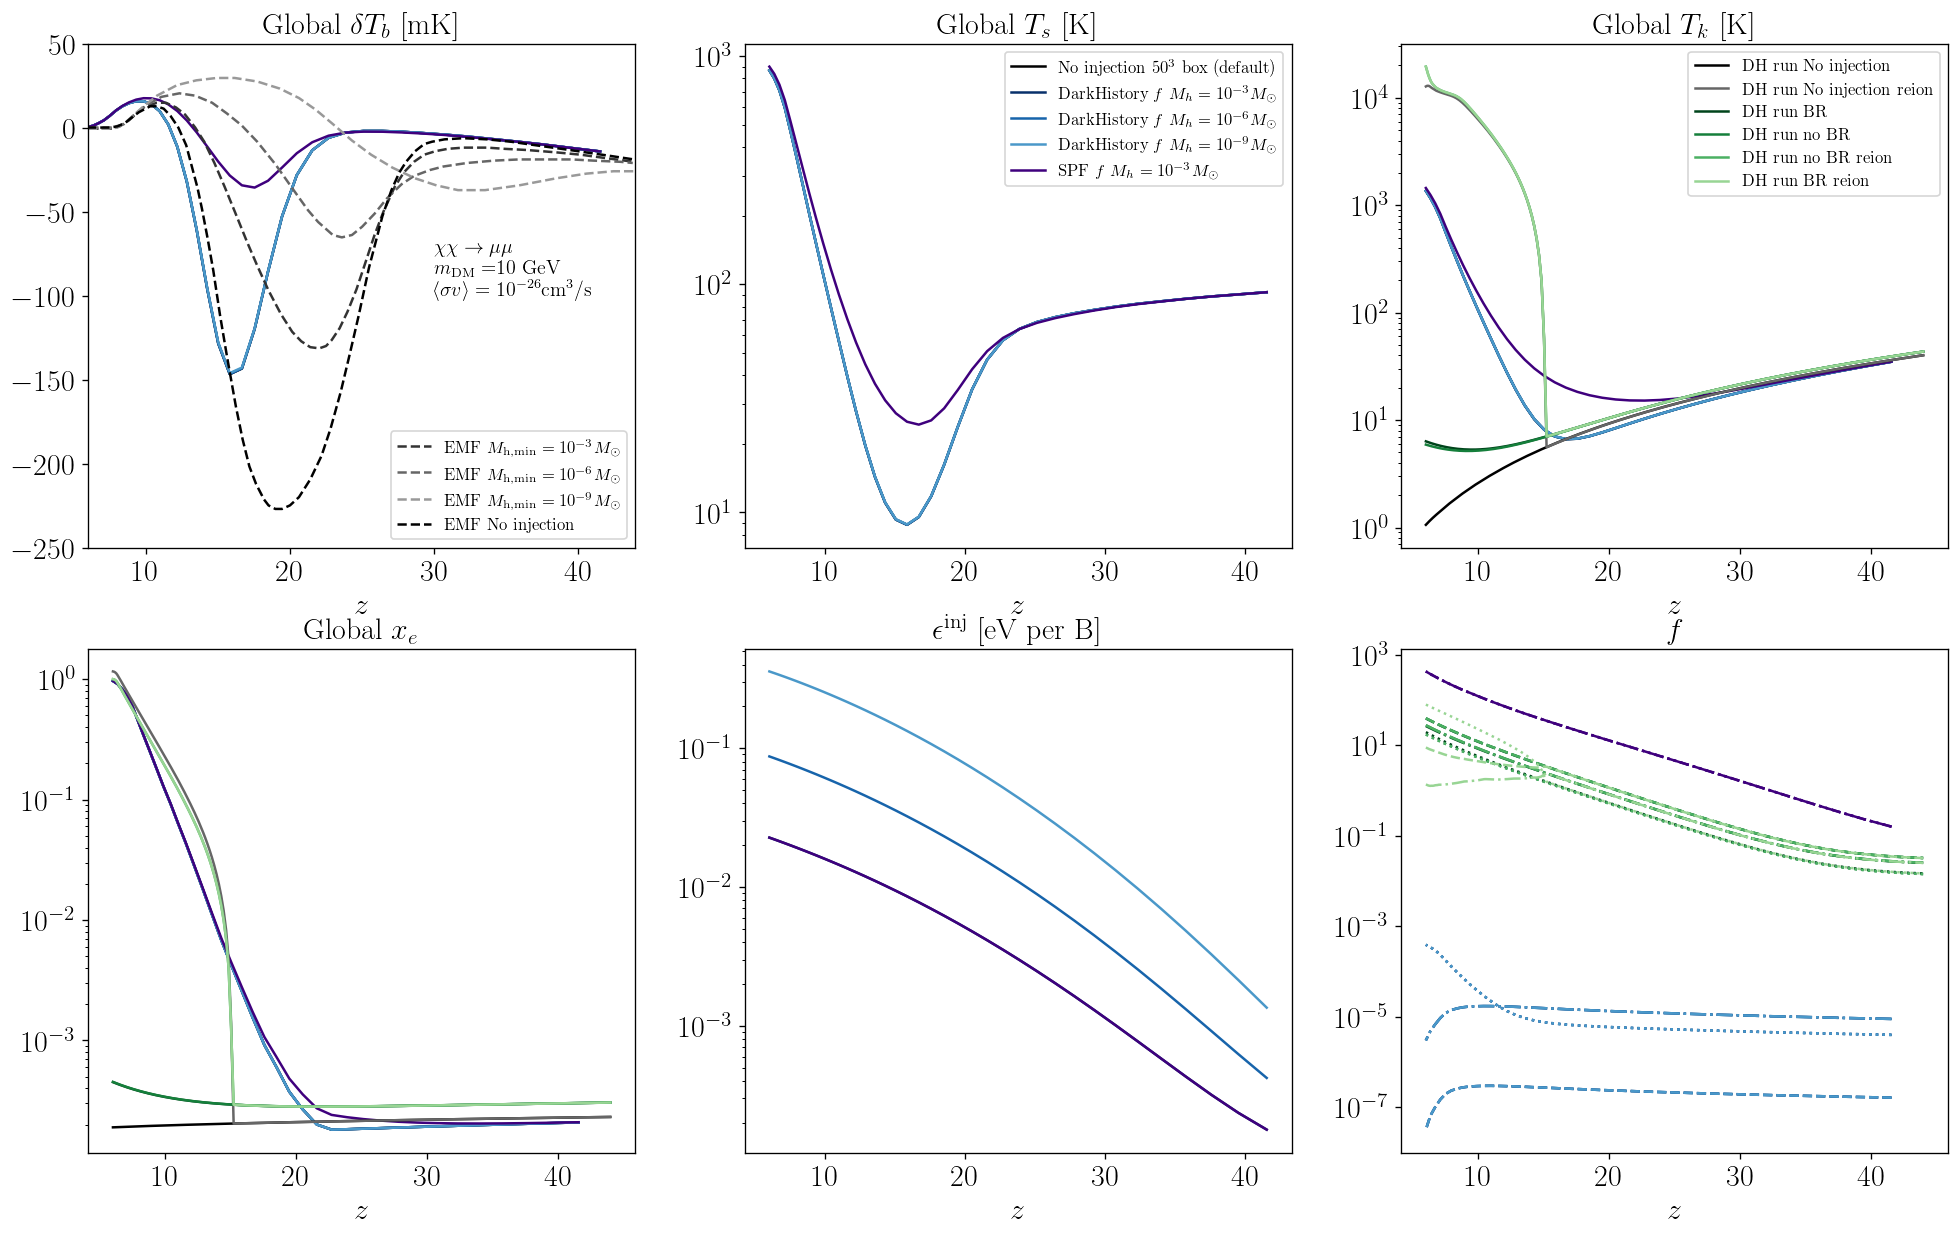

In [40]:
plot_options = {
    'base'     : dict(color='black'),
    #'base_large' : dict(color='gray', linestyle=':', label=r'No injection $100^3$ box'),
    'dh_mh3'   : dict(color=cm.get_cmap('Blues')(1.0)),
    'dh_mh6'   : dict(color=cm.get_cmap('Blues')(0.8)),
    'dh_mh9'   : dict(color=cm.get_cmap('Blues')(0.6)),
    'spf_mh3'  : dict(color=cm.get_cmap('Purples')(1.0)),
    #'dh_nolya' : dict(color='purple', label=r'DarkHistory no lya $f$'),
    #'ck'       : dict(color='green', label=r'CK $f$'),
    #'evfy'     : dict(color='red', label=r'EVFY $f$'),
    'emf_base' : dict(color=cm.get_cmap('binary')(1.0), linestyle='--'),
    'emf_mh3'  : dict(color=cm.get_cmap('binary')(0.8), linestyle='--'),
    'emf_mh6'  : dict(color=cm.get_cmap('binary')(0.6), linestyle='--'),
    'emf_mh9'  : dict(color=cm.get_cmap('binary')(0.4), linestyle='--'),
    'rundh_mh3'             : dict(color=cm.get_cmap('Greens')(1.0)),
    'rundh_mh3_noBR'        : dict(color=cm.get_cmap('Greens')(0.8)),
    'rundh_mh3_noBR_reion'  : dict(color=cm.get_cmap('Greens')(0.6)),
    'rundh_mh3_reion'       : dict(color=cm.get_cmap('Greens')(0.4)),
    'rundh_base'       : dict(color=cm.get_cmap('binary')(1.0)),
    'rundh_base_reion' : dict(color=cm.get_cmap('binary')(0.6)),
}

labels = {
    'T_b' : {
        'emf_base' : r'EMF No injection',
        'emf_mh3'  : r'EMF $M_\mathrm{h,min}=10^{-3}M_\odot$',
        'emf_mh6'  : r'EMF $M_\mathrm{h,min}=10^{-6}M_\odot$',
        'emf_mh9'  : r'EMF $M_\mathrm{h,min}=10^{-9}M_\odot$',
    },
    'T_s' : {
        'base' : r'No injection $50^3$ box (default)',
        'dh_mh3' : r'DarkHistory $f$ $M_h=10^{-3}M_\odot$',
        'dh_mh6' : r'DarkHistory $f$ $M_h=10^{-6}M_\odot$',
        'dh_mh9' : r'DarkHistory $f$ $M_h=10^{-9}M_\odot$',
        'spf_mh3' : r'SPF $f$ $M_h=10^{-3}M_\odot$',
    },
    'T_k' : {
        'rundh_mh3' : 'DH run BR',
        'rundh_mh3_noBR' : 'DH run no BR',
        'rundh_mh3_noBR_reion' : 'DH run no BR reion',
        'rundh_mh3_reion' : 'DH run BR reion',
        'rundh_base' : 'DH run No injection',
        'rundh_base_reion' : 'DH run No injection reion',
    },
}

emf_plots = {
    'emf_mh3'  : np.loadtxt('plots/EMF/mhmin1e-3.txt', unpack=True, skiprows=1),
    'emf_mh6'  : np.loadtxt('plots/EMF/mhmin1e-6.txt', unpack=True, skiprows=1),
    'emf_mh9'  : np.loadtxt('plots/EMF/mhmin1e-9.txt', unpack=True, skiprows=1),
    'emf_base' : np.loadtxt('plots/EMF/base.txt', unpack=True, skiprows=1),
}

fig, axs = plt.subplots(2, 3, figsize=(20, 12))

#for name in ['base', 'base_large', 'dh3', 'ck', 'evfy']:
for name in ['base', 'dh_mh3', 'dh_mh6', 'dh_mh9', 'spf_mh3',
             'rundh_base', 'rundh_base_reion',
             'rundh_mh3', 'rundh_mh3_noBR', 'rundh_mh3_noBR_reion', 'rundh_mh3_reion']:
    
    if 'rundh' not in name:
        run_name = 'emf_comp_' + name
    else:
        run_name = name
    records = np.load(f'../data/run_info/{run_name}_records.npy', allow_pickle=True).item()
    
    if 'rundh' not in name:
        axs[0,0].plot(records['z'], records['T_b'],
                      label=(labels['T_b'][name] if name in labels['T_b'].keys() else None), **plot_options[name])
        axs[0,1].plot(records['z'], records['T_s'],
                      label=(labels['T_s'][name] if name in labels['T_s'].keys() else None), **plot_options[name])
    axs[0,2].plot(records['z'], records['T_k'],
                  label=(labels['T_k'][name] if name in labels['T_k'].keys() else None), **plot_options[name])
    axs[1,0].plot(records['z'], records['x_e'], **plot_options[name])
    
    if ('base' not in name) and ('rundh' not in name):
        axs[1,1].plot(records['z'], records['dE_inj_per_B'], **plot_options[name])
        
    if 'base' not in name:
        if 'spf' in name:
            factor = phys.struct_boost_func('erfc 1e-3')(records['z'])
        else:
            factor = 1
        axs[1,2].plot(records['z'], factor*records['f_heat'], linestyle=':', **plot_options[name])
        axs[1,2].plot(records['z'], factor*records['f_ion'], linestyle='--', **plot_options[name])
        axs[1,2].plot(records['z'], factor*records['f_exc'], linestyle='-.', **plot_options[name])
        
for name in ['emf_mh3', 'emf_mh6', 'emf_mh9', 'emf_base']:
    axs[0,0].plot(*emf_plots[name], label=labels['T_b'][name], **plot_options[name])

axs[0,0].set(title=r'Global $\delta T_b$ [mK]', xlabel=r'$z$')
axs[0,1].set(title=r'Global $T_s$ [K]', xlabel=r'$z$')
axs[0,2].set(title=r'Global $T_k$ [K]', xlabel=r'$z$')
axs[1,0].set(title=r'Global $x_e$', xlabel=r'$z$')
axs[1,1].set(title=r'$\epsilon^\mathrm{inj}$ [eV per B]', xlabel=r'$z$')
axs[1,2].set(title=r'$f$', xlabel=r'$z$')

axs[0,0].set(xlim=(6, 44), ylim=(-250, 50))
axs[0,1].set(yscale='log')
axs[0,2].set(yscale='log')
axs[1,0].set(yscale='log')
axs[1,1].set(yscale='log')
axs[1,2].set(yscale='log')

axs[0,0].text(30, -100, r'$\chi\chi\rightarrow\mu\mu$' + '\n' + \
             r'$m_\mathrm{DM}=$10~GeV' + '\n' + \
             r'$\langle\sigma v\rangle=10^{-26}\mathrm{cm}^3/\mathrm{s}$', fontsize=12)
axs[0,0].legend(fontsize=10)
axs[0,1].legend(fontsize=10)
axs[0,2].legend(fontsize=10)

In [52]:
from dm21cm.injection import get_SPF_f_boxs

In [53]:
get_SPF_f_boxs([0.], 8., dm_params)

{'heat': array([0.0571042]),
 'ion': array([0.0571042]),
 'exc': array([0.0571042])}

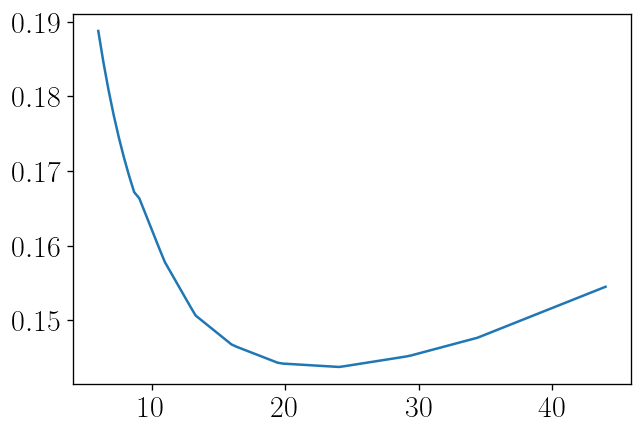

In [56]:
xs = np.linspace(6, 44, 100)
ys = [get_SPF_f_boxs([0.], x, dm_params)['heat'].item()*3 for x in xs]
plt.plot(xs, ys)

### 2.2 slices

In [20]:
! rm plots/tmp/*

In [23]:
title={
    'delta' : r'$\delta_\mathrm{DM/B}$',
    'T_s'   : r'$T_\mathrm{spin}$ [mK]',
    'x_e'   : r'$x_e$',
    'heat'  : r'$\epsilon_\mathrm{heat}$ [eV s$^{-1}$ per B]',
    'heat_dT' : r'heat $\Delta T$',
    'ion'   : r'$\epsilon_\mathrm{ion}$ [eV s$^{-1}$ per B]',
    'exc'   : r'$\epsilon_\mathrm{exc}$',
    'T_b'   : r'$T_b$ [mK]',
}
vrange={
    'delta' : (-0.25, 0.75),
    'T_s'   : (60., 100.),
    'x_e'   : (0., 0.002),
    'heat'  : (0., 7e-18),
    'heat_dT' : (0, 40),
    'ion'   : (0., 7e-18),
    'exc'   : (0., 1.),
    'T_b'   : (-20., 0.)
}

for i_z, record in enumerate(tqdm(records)):

    n_col = len(record.items())
    fig, axs = plt.subplots(1, n_col, figsize=(3*n_col, 4))
    for i, (k, x) in enumerate(record.items()):
        im = axs[i].imshow(x, vmin=vrange[k][0], vmax=vrange[k][1])
        axs[i].set(title=title[k], xticks=[], yticks=[])
        axs[i].text(28, 47, f'z={z_arr[i_z]:.3f}', color='w')
        fig.colorbar(im, ax=axs[i], orientation='horizontal', shrink=0.9)
    fig.savefig(f'plots/tmp/{i_z}.png')
    plt.close()

100%|██████████| 37/37 [00:34<00:00,  1.08it/s]


In [24]:
import glob
import contextlib
from PIL import Image

# filepaths
fp_in = "plots/tmp/*.png"
fp_out = "plots/DH.gif"

# use exit stack to automatically close opened images
flist = glob.glob(fp_in)
with contextlib.ExitStack() as stack:
    imgs = (stack.enter_context(Image.open(f))
            for f in sorted(flist, key=lambda x: int(os.path.basename(x).split('.')[0])))
    # extract  first image from iterator
    durations = np.full(len(flist), 500)
    durations[-1] = 1500
    img = next(imgs)

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=list(durations), loop=0)

### 2.3 lightcone

In [ ]:
p21c.run_lightcone(redshift=5)

# Archive

## A. Some uniform calculation for scale

In [25]:
swave_process = dict(
    mode = 'swave',
    mDM = 2e6, # [eV]
    sigmav = 1e-26, # [cm^3 s^-1]
)
decay_process = dict(
    mode = 'decay',
    mDM = 4e6, # [eV]
    lifetime = 3e25, # [s]
)
process = swave_process

$$\mathcal{E}^{inj}=\frac{1}{n_B}\frac{dE}{dtdV}=(1+z)^3\frac{\Omega_{DM}^2}{\Omega_B}\rho_c(1+B(z))m_pc^2\frac{\langle\sigma v\rangle}{m_{DM}}$$

In [26]:
E_inj = phys.omega_DM**2 / phys.omega_baryon * phys.rho_crit * phys.m_p * process['sigmav'] / process['mDM']
print(f"E_inj = (1+z)^3 (1+B) * {E_inj:.4e} eV / s")

E_inj = (1+z)^3 (1+B) * 3.1821e-20 eV / s


$$\epsilon^{DM}_{heat}=f_{heat}\mathcal{E}^{inj}$$

In [27]:
z_high, z_low = 34.91712652, 33.20678716
delta_B = jnp.array([0.])
x_e = jnp.array([0.1])
f_boxs = get_DH_f_boxs(delta_B, x_e, z=z_high, **process)

eDMheat = (1+z_high)**3 * f_boxs['heat'].flatten()[0] * E_inj
print(f"e_DM_heat = (1+B) * {eDMheat:.4e} eV / s")

e_DM_heat = (1+B) * 1.1110e-19 eV / s


$$\Delta T=\frac{2}{3k_B(1+x_e)}\,\Delta t\,\epsilon^{DM}_{heat}$$

In [28]:
dT =  2 / (3*phys.kB) * phys.dt_between_z(z_high, z_low) * eDMheat / (1+x_e[0])
print(f"dT = (1+B) * {1000*dT:.4f} mK")

dT = (1+B) * 149.2254 mK


## B. Plotting

[Text(0.5, 1.0, 'input ionization'), [], []]

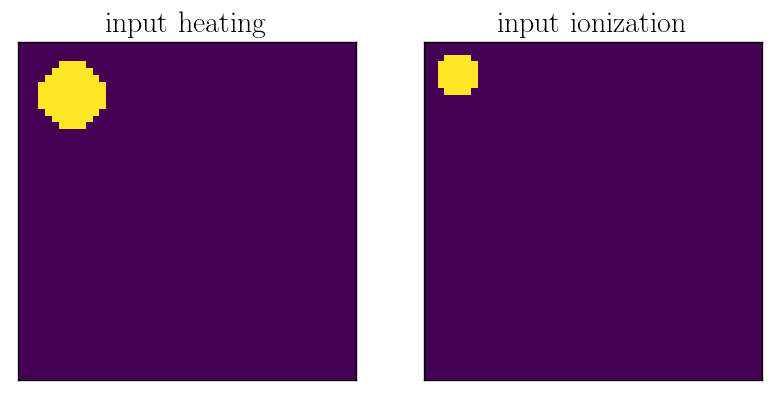

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
im0 = axs[0].imshow(input_heating.input_heating[25])
im1 = axs[1].imshow(input_ionization.input_ionization[25])

axs[0].set(title=r'input heating', xticks=[], yticks=[])
axs[1].set(title=r'input ionization', xticks=[], yticks=[])

#fig.colorbar(im0, ax=axs[0], orientation='horizontal')
#fig.colorbar(im1, ax=axs[1], orientation='horizontal')

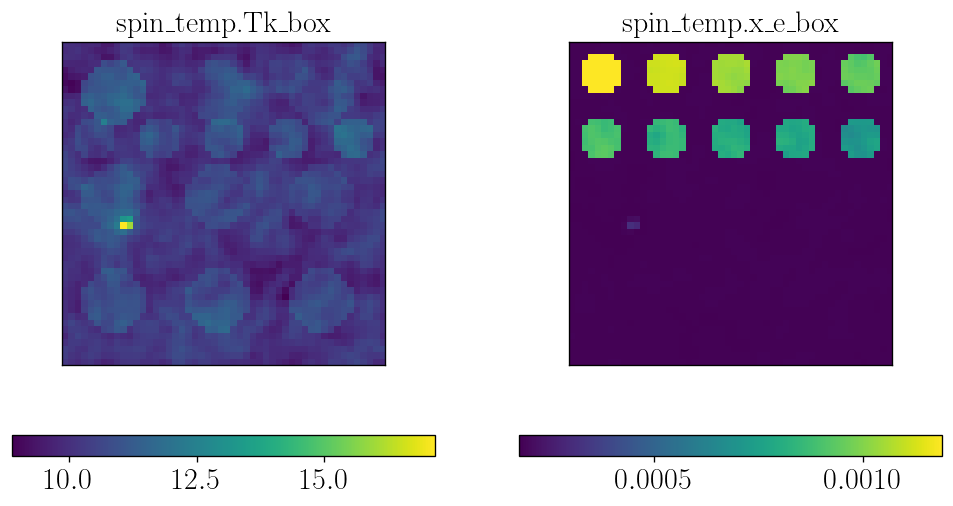

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
im0 = axs[0].imshow(spin_temp.Tk_box[25])
im1 = axs[1].imshow(spin_temp.x_e_box[25])

axs[0].set(title='spin_temp.Tk_box', xticks=[], yticks=[])
axs[1].set(title='spin_temp.x_e_box', xticks=[], yticks=[])

fig.colorbar(im0, ax=axs[0], orientation='horizontal')
fig.colorbar(im1, ax=axs[1], orientation='horizontal')